In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
from pathlib import Path
import pdb
import importlib
from scipy.io import readsav
import pickle
import gx_chromo.combo_model
import importlib
import json
import datetime
from astropy.time import Time

nlfff_libpath = (Path('./nlfff/binaries/WWNLFFFReconstruction.so').resolve())
radio_libpath = "./rendergrff/binaries/RenderGRFF.so"

os.environ['OMP_NUM_THREADS']='16' # number of parallel threads

from contrib.MagFieldWrapper import MagFieldWrapper
from contrib.radio import GXRadioImageComputing

font = {"weight": "normal", "size": 12}
mpl.rc("font", **font)

In [2]:
#del GXRadioImageComputing
#del sys.modules["radio"]

In [14]:
conf_path = Path("./test_files.json").resolve()
if not conf_path.exists():
    print("does not exist, using default parameters")
    data_path = (Path("./data")).resolve()
    pot_path = data_path / "test.POT.sav"
    bndpath = data_path / "test.BND.sav"
    ebtel_file = "/path/to/your/gx_simulator/userslib/aia/ebtel/ebtel.sav"
    jsoc_email = "test@example.com"
else:
    config = json.load(open(str(conf_path), "rb"))
    pot_path = config["pot_path"]
    bndpath = config["bnd_path"]
    ebtel_file = config["ebtel_file"]
    jsoc_email = config["jsoc_email"]

In [4]:
%%time

maglib = MagFieldWrapper(nlfff_libpath)

print('Load potential cube ...')
maglib.load_cube(pot_path)
energy_pot = maglib.energy
print('Potential energy: ' + str(energy_pot) + ' erg')

print('Load photoshere bounded cube ...')
maglib.load_cube(bndpath)
print('Calculate NLFFF ...')
box = maglib.NLFFF()
energy_new = maglib.energy
print('NLFFF energy:     ' + str(energy_new) + ' erg')

print("Calculating field lines")
lines = maglib.lines(seeds = None)

Load potential cube ...
Potential energy: 5.25976502130115e+32 erg
Load photoshere bounded cube ...
Calculate NLFFF ...
NLFFF energy:     6.216397209179598e+32 erg
Calculating field lines
CPU times: user 1h 54min 10s, sys: 19min 12s, total: 2h 13min 22s
Wall time: 26min 54s


In [5]:
bndbox = readsav(bndpath, python_dict=True)["box"]

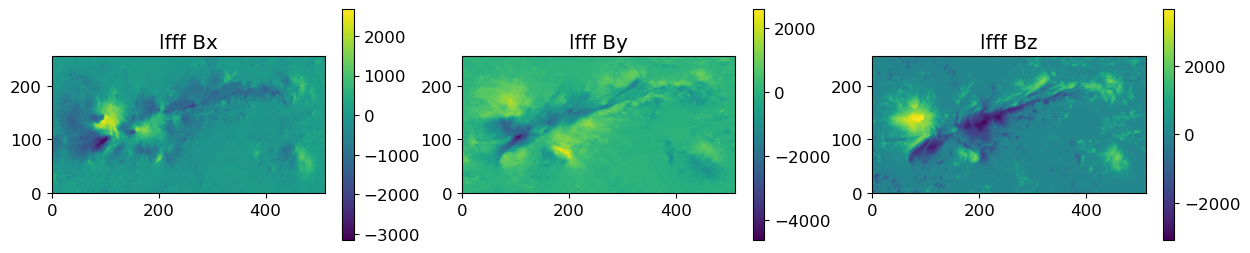

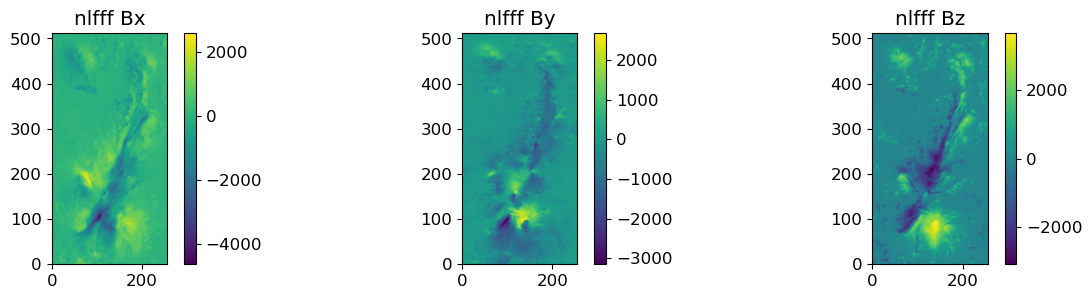

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
axes = (ax1, ax2, ax3)

for a, arr, ttl in zip(axes, (bndbox["bx"], bndbox["by"], bndbox["bz"]), ("Bx", "By", "Bz")):
    im = a.imshow(arr[0][0, :, :], origin="lower")
    plt.colorbar(im, ax=a)
    a.set_title("lfff " + ttl)
fig.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
axes = (ax1, ax2, ax3)

for a, arr, ttl in zip(axes, (box["bx"], box["by"], box["bz"]), ("Bx", "By", "Bz")):
    im = a.imshow(arr[0, :, :], origin="lower")
    plt.colorbar(im, ax=a)
    a.set_title("nlfff " + ttl)
fig.show()

In [6]:
bndbox["dr"][0]

array([0.00051796, 0.00051796, 0.00051796], dtype='>f8')

In [7]:
chromo_box=gx_chromo.combo_model.combo_model_idl(bndbox, box)

cutoff_qs:  0.9872897587143802 14131
cutoff_b:  1.0074705648009001
cutoff_f:  1.0357057670148673
umbra: nelem=  15744  abs(B) range:  0.08795370033654049 3644.501680914637
penumbra: nelem=  28107  abs(B) range:  0.0264753745335507 2087.409023124798
eNW: nelem=  2617  abs(B) range:  0.002047932029135318 1361.782372766335
NW: nelem=  19188  abs(B) range:  0.003994815976981855 1344.1481798170337
IN: nelem=  65416  abs(B) range:  6.759436274499792e-05 1724.9467305150138
plage: nelem=  44697  abs(B) range:  30.002322356988575 1471.1121214887253
facula: nelem=  19282  abs(B) range:  30.003666496305556 1361.782372766335
Total elements:  195051
Number of elements in cont:  131072


In [8]:
box["bx"].shape

(256, 512, 256)

In [9]:
chromo_box["avfield"] = lines["av_field"].transpose((1, 2, 0))
chromo_box["physlength"] = lines["phys_length"].transpose((1, 2, 0)) * bndbox["dr"][0][0]
chromo_box["status"] = lines["voxel_status"].transpose((1, 2, 0))

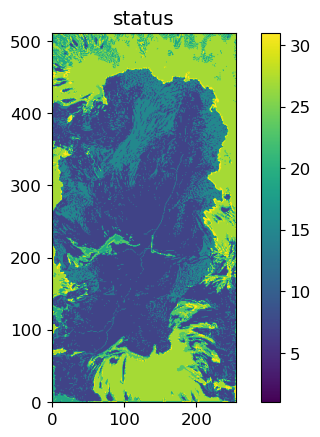

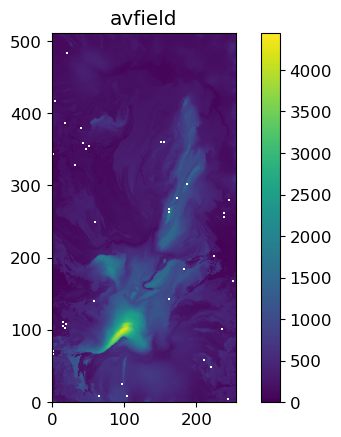

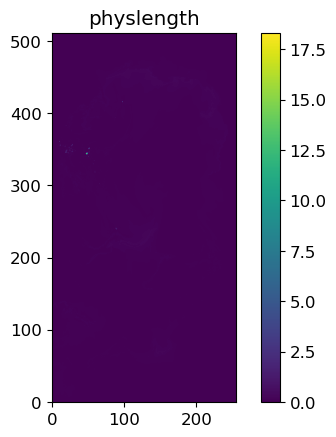

In [48]:
for k in ("status", "avfield", "physlength"):
    plt.figure()
    plt.title(k)
    plt.imshow(chromo_box[k][:, :, 1], origin="lower", interpolation=None)
    plt.colorbar()
    plt.show()

In [38]:
header = {}
for val, val1 in zip(("CRVAL1", "CRVAL2", "DATE_OBS", "DSUN_OBS"),
                  ("lon", "lat", "obs_time", "dsun_obs")
                 ):
    header[val1] = bndbox["index"][0][val][0]

In [39]:
header["obs_time"] = Time(header["obs_time"].decode("utf-8"))
header

{'lon': 112.861468008,
 'lat': -12.3699309984,
 'obs_time': <Time object: scale='utc' format='isot' value=2014-02-02T02:22:10.300>,
 'dsun_obs': 147429902184.0}

In [12]:
gxi = GXRadioImageComputing(radio_libpath)

In [40]:
ebtel, ebtel_dt = gxi.load_ebtel(ebtel_file)
model, model_dt = gxi.load_model_dict(chromo_box, header)

box_Nx=150
box_Ny=150
box_xc=-230
box_yc=-110
box_dx=2.0
box_dy=2.0

freqlist=[17.0, 34.0]

Tbase=1e6
nbase=1e8
Q0=4.5e-3
a=1.5
b=2.5

results = gxi.synth_model(model, model_dt,
                          ebtel, ebtel_dt, freqlist,
                          box_Nx, box_Ny, box_xc, box_yc, box_dx, box_dy, Tbase, nbase, Q0, a, b, force_isothermal=1)

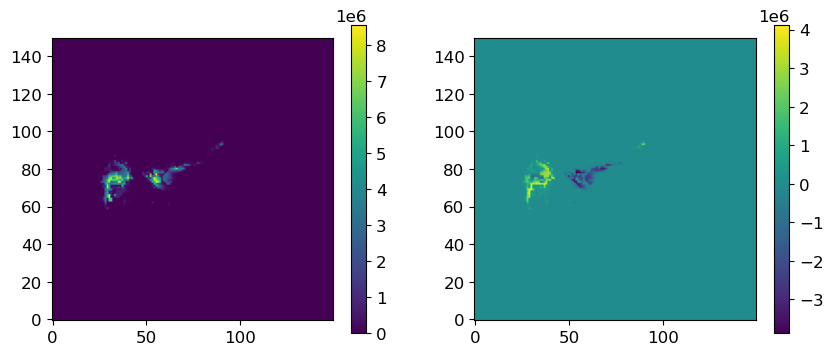

In [41]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
i1 = ax1.imshow(np.transpose(results["TI"][:, :, 0]), origin='lower')
i2 = ax2.imshow(np.transpose(results["TV"][:, :, 0]), origin='lower')

plt.colorbar(i1, ax=ax1)
plt.colorbar(i2, ax=ax2)

plt.show()

In [42]:
results["TI"][20:80, 60:100, 0]

array([[17221.91183756, 21657.74124124, 17147.75492022, ...,
        15355.8222624 , 15430.31539411, 14633.53193119],
       [16296.41593531, 17729.2123472 , 18725.41532487, ...,
        14219.28167129, 17140.77052652, 17872.94760218],
       [16033.92433807, 16365.51033119, 17976.11532582, ...,
        14380.61655285, 18052.82749226, 17772.68719817],
       ...,
       [16669.95776778,  7018.40039833, 13561.45587317, ...,
        17176.74051119, 19255.33347263, 18654.25687573],
       [16640.38991176, 13565.36710464, 13577.9772281 , ...,
        17107.39832344, 16022.71965604, 18524.54582128],
       [16587.65764113, 16669.37304146, 16683.87125574, ...,
        16385.18765402, 18941.90359586, 18393.17546768]])